In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from IPython import display
import math

In [2]:
from torch.utils.data import DataLoader, TensorDataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/Multi_core/preprocessed_data.csv')
# data = pd.read_csv('../data/prepocessed_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dropped_col = ['Speedup']

In [5]:
X = data.drop(dropped_col, axis=1).values
y = data[dropped_col].values

In [6]:
# train test split
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

In [7]:
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_val_tensor = torch.from_numpy(X_val)
y_val_tensor = torch.from_numpy(y_val)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

In [8]:
print("X_train_Size: " + str(X_train_tensor.shape))
print("y_train_Size: " + str(y_train_tensor.shape))
print("X_val_Size: " + str(X_val_tensor.shape))
print("y_val_Size: " + str(y_val_tensor.shape))
print("X_test: " + str(X_test_tensor.shape))
print("y_test_Size: " + str(y_test_tensor.shape))

X_train_Size: torch.Size([7287, 27])
y_train_Size: torch.Size([7287, 1])
X_val_Size: torch.Size([1562, 27])
y_val_Size: torch.Size([1562, 1])
X_test: torch.Size([1562, 27])
y_test_Size: torch.Size([1562, 1])


In [9]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [10]:
I = 27  # input feature
O = 1 # output result
H = 64 # hidden unit

In [11]:
model = nn.Sequential(
    nn.Linear(I, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, O)
)
model = model.to(torch.float64)

In [12]:
weight_tensor = model[0].weight

# Get the datatype of the weight tensor
weight_tensor.dtype

torch.float64

In [13]:
X_train_tensor.dtype

torch.float64

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
def train(model, loader, optimizer):
    loss_sum = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(loader):
        optimizer.zero_grad()
        output = model(inputs)
        loss = torch.nn.functional.mse_loss(output, targets)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        
    avg_loss = loss_sum / len(loader)
    print(f"Train MSE loss: {avg_loss:.4f}")
    return avg_loss

In [16]:
train_losses = []
train_rmses = []
train_maes = []
val_losses = []
val_rmses = []
val_maes = []

In [17]:
#train
for epoch in range(200):
    print(f"Epoch {epoch + 1}")
    train_loss = train(model, train_loader, optimizer)
    train_losses.append(train_loss)

    with torch.no_grad():
        mae_sum = 0.0
        rmse_sum = 0.0
        total = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            output = model(inputs)
            mae_sum += torch.abs(output - targets).sum().item()
            rmse_sum += torch.square(output - targets).sum().item()
            total += len(targets)
        mae = mae_sum / total
        rmse = math.sqrt(rmse_sum / total)
        train_rmses.append(rmse)
        train_maes.append(mae)
        print(f"Train MSE: {train_loss:.4f}, Train MAE: {mae:.4f}, Train RMSE: {rmse:.4f}")
    
    # validation
    with torch.no_grad():
        loss_sum = 0.0
        val_mae_sum = 0.0
        val_rmse_sum = 0.0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            output = model(inputs)
            loss = torch.nn.functional.mse_loss(output, targets)
            loss_sum += loss.item()
            val_mae_sum += torch.abs(output - targets).sum().item()
            val_rmse_sum += torch.square(output - targets).sum().item()
            total += len(targets)

        avg_loss = loss_sum / len(test_loader)
        val_losses.append(avg_loss)
        val_mae = val_mae_sum / total
        val_rmse = math.sqrt(val_rmse_sum / total)
        val_rmses.append(val_rmse)
        val_maes.append(val_mae)
        print(f"Test MSE: {avg_loss:.4f}, Test MAE: {val_mae:.4f}, Test RMSE: {val_rmse:.4f}")
    # display.clear_output(wait=True)

Epoch 1
Train MSE loss: 1983904410150237.5000
Train MSE: 1983904410150237.5000, Train MAE: 7866888.2434, Train RMSE: 12230237.8218
Test MSE: 149794606620921.7188, Test MAE: 7676849.1310, Test RMSE: 12256668.5208
Epoch 2
Train MSE loss: 293725083310355.2500
Train MSE: 293725083310355.2500, Train MAE: 8849836.1240, Train RMSE: 13072640.2624
Test MSE: 153607435075707.3750, Test MAE: 8526020.0656, Test RMSE: 12414422.4153
Epoch 3
Train MSE loss: 727764249603993.0000
Train MSE: 727764249603993.0000, Train MAE: 12918526.2801, Train RMSE: 20648991.1797
Test MSE: 393046576796173.8750, Test MAE: 11972541.4553, Test RMSE: 19846072.1927
Epoch 4
Train MSE loss: 60791277027974.7422
Train MSE: 60791277027974.7422, Train MAE: 1467643.1906, Train RMSE: 2308060.8938
Test MSE: 4639305164799.9473, Test MAE: 1392765.3697, Test RMSE: 2156803.7424
Epoch 5
Train MSE loss: 1294401979934781.2500
Train MSE: 1294401979934781.2500, Train MAE: 3191160.6769, Train RMSE: 6352816.5291
Test MSE: 36326503185577.4375, T

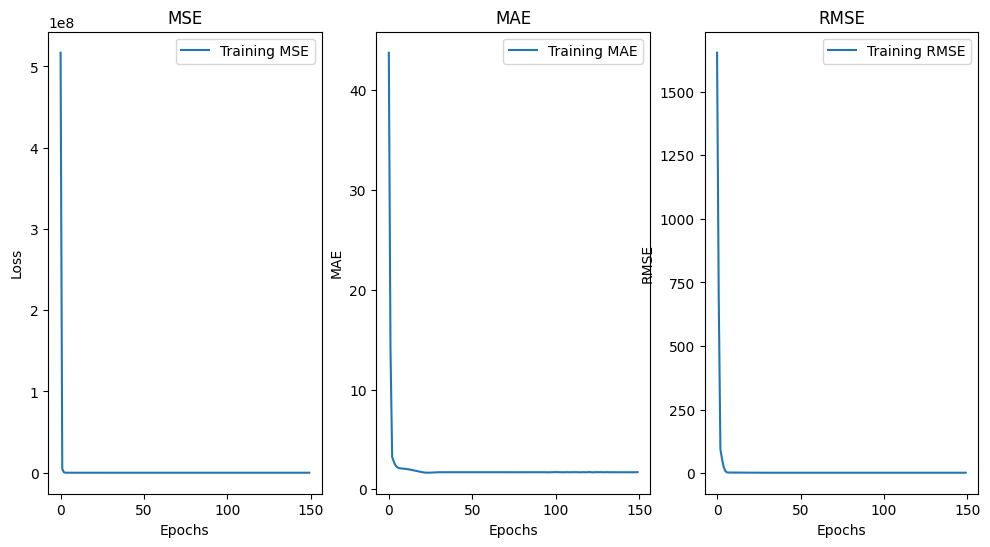

In [21]:
# train loss, mae, rmse
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# plot the MSE values
ax1.plot(train_losses[50:], label='Training MSE')
ax1.set_title('MSE')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# plot the MAE values
ax2.plot(train_maes[50:], label='Training MAE')
ax2.set_title('MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.legend()

# plot the RMSE values
ax3.plot(train_rmses[50:], label='Training RMSE')
ax3.set_title('RMSE')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('RMSE')
ax3.legend()

# show the plot
plt.show()

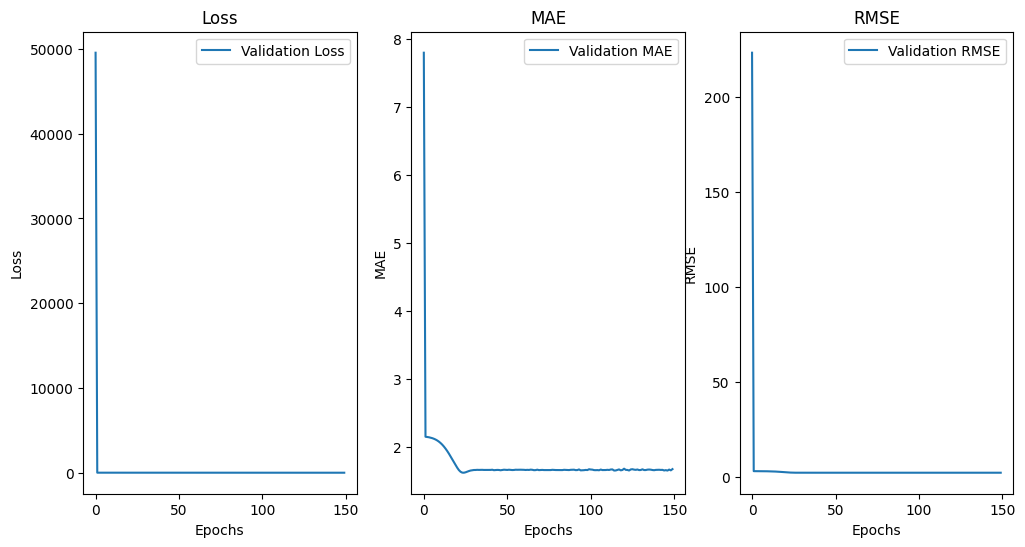

In [22]:
# val loss, accuracy
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# plot the MSE values
ax1.plot(val_losses[50:], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# plot the MAE values
ax2.plot(val_maes[50:], label='Validation MAE')
ax2.set_title('MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.legend()

# plot the RMSE values
ax3.plot(val_rmses[50:], label='Validation RMSE')
ax3.set_title('RMSE')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('RMSE')
ax3.legend()

# show the plot
plt.show()